# Lecture Notes: Preventing Data Leakage and Building Robust Machine Learning Pipelines

In these notes, we cover how to simulate and visualize data, understand the dangers of data leakage, and build robust machine learning pipelines. Our example focuses on forecasting ice cream sales.

## Table of Contents
1. **Introduction: Ice Cream Sales Forecasting**
2. **An Incorrect Approach**
3. **Train, Validation, and Test Datasets**
4. **The ML Pipeline**
5. **A Better Approach**
6. **Summary and Best Practices**

## 1. Introduction: Ice Cream Sales Forecasting

In this lecture, we explore the steps required to forecast ice cream sales while avoiding data leakage. We cover how to simulate data, split and preprocess it, and how to build a robust pipeline that ensures every step—from data preparation to evaluation—is properly executed. Finally, we explain the importance of saving your trained model for future use.

*(The following cells also include setting up our environment, simulating sales data, and visualizing it.)*

<a name="setting-up"></a>
### Setting Up: Importing Required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import pickle  # For model serialization

print("All libraries have been successfully imported.")

All libraries have been successfully imported.


<a name="data-simulation"></a>
### Data Simulation: Creating Sales Data

We simulate 90 days of ice cream sales data. The features include:

- **Temperature:** Simulated using a normal distribution (mean = 25°C, standard deviation = 3).
- **Promotion:** A binary variable indicating whether a promotion is active (1) or not (0), with a 30% chance of promotion.

Sales are computed using the formula:

  sales = 300 + 12 × temperature + 60 × promotion + random noise (mean = 0, std = 20)

This formula mimics a scenario where higher temperatures and promotions increase sales.

In [3]:
np.random.seed(42)

# 1. Generate dates (90 days)
n_days = 90
start_date = datetime(2024, 1, 1)
dates = [start_date + timedelta(days=i) for i in range(n_days)]

# 2. Generate temperature and promotion features
temperatures = np.random.normal(loc=25, scale=3, size=n_days).round(1)
promotions = np.random.choice([0, 1], size=n_days, p=[0.7, 0.3])

# 3. Compute sales using the given formula
sales = 300 + 12 * temperatures + 60 * promotions + np.random.normal(0, 20, size=n_days)

# 4. Create a DataFrame
df = pd.DataFrame({
    'date': dates,
    'temperature': temperatures,
    'promotion': promotions,
    'sales': sales.round().astype(int)
})

print(df.head())
print("\n(Data simulation successful.)")

        date  temperature  promotion  sales
0 2024-01-01         26.5          1    715
1 2024-01-02         24.6          0    605
2 2024-01-03         26.9          1    659
3 2024-01-04         29.6          1    728
4 2024-01-05         24.3          0    572

(Data simulation successful.)


<a name="data-visualization"></a>
### Data Visualization: Spotting Trends

Visualizing the data helps us understand patterns. We will create two visualizations:

1. **Scatter Plot (Temperature vs Sales):** This plot shows how temperature and promotions influence sales.
2. **Boxplot (Promotion vs Sales):** This plot compares sales on days with and without promotions.

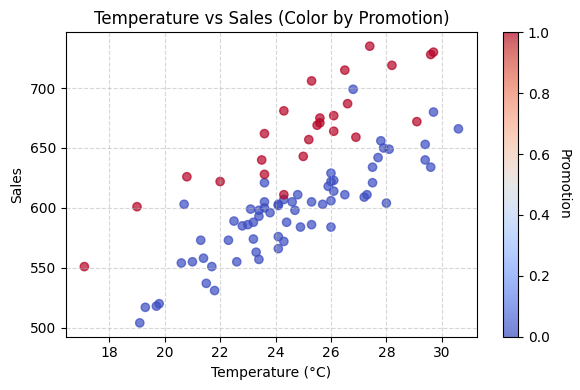

In [4]:
plt.figure(figsize=(6,4))
plt.scatter(df['temperature'], df['sales'], c=df['promotion'], cmap='coolwarm', alpha=0.7)
plt.title('Temperature vs Sales (Color by Promotion)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Sales')
cbar = plt.colorbar()
cbar.set_label('Promotion', rotation=270, labelpad=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

<ipython-input-5-db3b700e9d66>:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_list, labels=labels)


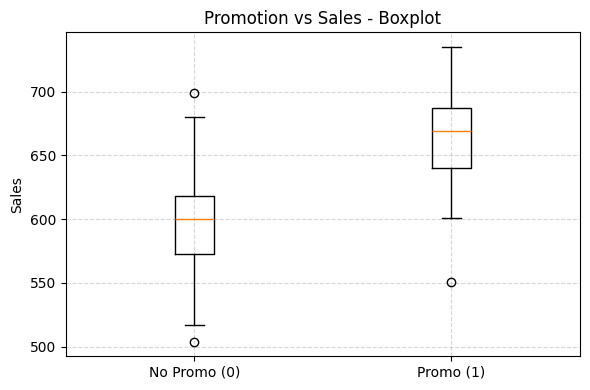

The boxplot shows higher sales during promotions.


In [5]:
plt.figure(figsize=(6,4))
groups = df.groupby('promotion')['sales']
labels = ['No Promo (0)', 'Promo (1)']
data_list = [groups.get_group(g) for g in sorted(groups.groups.keys())]
plt.boxplot(data_list, labels=labels)
plt.title('Promotion vs Sales - Boxplot')
plt.ylabel('Sales')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("The boxplot shows higher sales during promotions.")

## 2. An Incorrect Approach

**2.1 Using the Entire Dataset**

A naïve approach is to use the entire dataset for both training and evaluation. Although the model may appear to perform well (a high R² score), this approach can conceal issues such as overfitting and does not reflect the model's true generalization capability.

In [6]:
print("=== Naïve Approach: Using the entire dataset for training and evaluation ===")

X_all = df[['temperature', 'promotion']]
y_all = df['sales']

model_all = RandomForestRegressor(random_state=42)
model_all.fit(X_all, y_all)

r2_all = model_all.score(X_all, y_all)
print(f"Model R^2 using the entire dataset: {r2_all:.4f}")

=== Naïve Approach: Using the entire dataset for training and evaluation ===
Model R^2 using the entire dataset: 0.9364


**2.2 Demonstrating Data Leakage**

Data leakage occurs when information from outside the training dataset is used to create the model. Here, a common mistake is to include the target variable as a feature. This example demonstrates how leakage can lead to unrealistically high performance.

In [7]:
print("=== Demonstrating Data Leakage ===")

X_leak = df[['temperature', 'promotion']].copy()
X_leak['target_leak'] = df['sales']  # Incorrectly adding the target as a feature
y_leak = df['sales']

X_train_leak, X_test_leak, y_train_leak, y_test_leak = train_test_split(
    X_leak, y_leak, test_size=0.2, random_state=42
)

leak_model = RandomForestRegressor(random_state=42)
leak_model.fit(X_train_leak, y_train_leak)

train_score_leak = leak_model.score(X_train_leak, y_train_leak)
test_score_leak = leak_model.score(X_test_leak, y_test_leak)

print(f"Training R^2 with leakage: {train_score_leak:.4f}")
print(f"Testing R^2 with leakage: {test_score_leak:.4f}")
print("Notice how the test score is suspiciously high—this indicates leakage.")

=== Demonstrating Data Leakage ===
Training R^2 with leakage: 0.9992
Testing R^2 with leakage: 0.9984
Notice how the test score is suspiciously high—this indicates leakage.


## 3. The ML Pipeline

In this section, we introduce the concept of an ML pipeline and illustrate one important aspect: the difference between **fit()** and **transform()**. This is demonstrated below using the temperature feature.

A comprehensive machine learning pipeline involves:

1. **Data Preparation and Cleaning:** Select and clean your features.
2. **Feature Engineering:** Create and select relevant features.
3. **Data Splitting:** Divide data into training, validation, and test sets.
4. **Model Selection and Training:** Experiment with and tune various models.
5. **Evaluation:** Rigorously assess model performance.
6. **Deployment and Monitoring:** Deploy the model and monitor its performance over time.

## 4. Train, Validation, and Test Datasets

In more advanced settings, data is often divided into three sets:

- **Training Set:** Used for model fitting.
- **Validation Set:** Used to fine-tune the model (e.g., hyperparameter tuning).
- **Test Set:** Used for a final unbiased evaluation of the model.

Additionally, environments like Anaconda allow for easy packaging and environment management, helping maintain reproducibility.

<a name="fit-vs-transform"></a>
### Detailed Illustration: fit() vs. transform()

When preprocessing, **fit()** calculates necessary parameters (e.g., mean and standard deviation) from the training data, while **transform()** applies those parameters to new data. It is critical to:

- Use `fit_transform()` **only** on the training data.
- Use `transform()` on the test data.

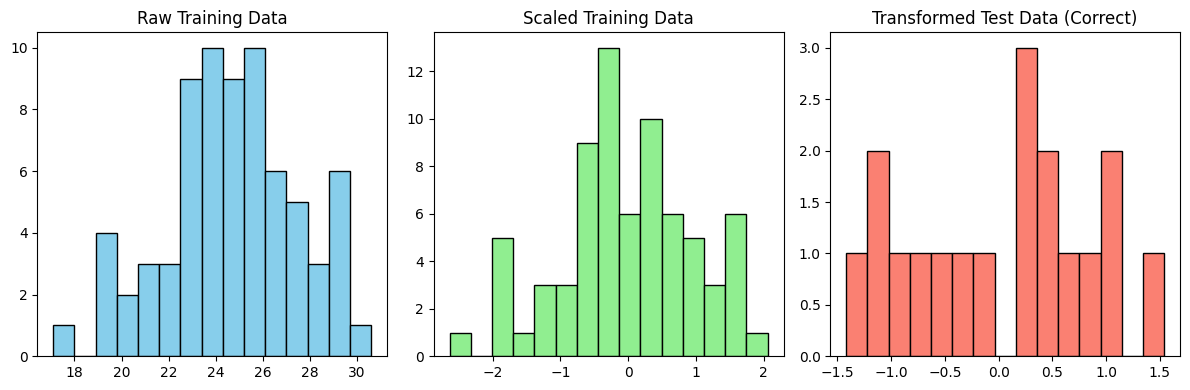

Correct approach: fit() applied on training data then transform() on test data.


In [8]:
# Using only the temperature feature for demonstration
X_ice = df[['temperature']]
y_ice = df['sales']

# Split the data
X_train_ice, X_test_ice, y_train_ice, y_test_ice = train_test_split(
    X_ice, y_ice, test_size=0.2, random_state=42
)

# Use the correct approach: fit on training data, transform test data
scaler_correct = StandardScaler()
X_train_ice_scaled_correct = scaler_correct.fit_transform(X_train_ice)
X_test_ice_scaled_correct = scaler_correct.transform(X_test_ice)

# Plot histograms of the raw training data, and the scaled training and test data
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(X_train_ice, bins=15, color='skyblue', edgecolor='black')
plt.title('Raw Training Data')

plt.subplot(1, 3, 2)
plt.hist(X_train_ice_scaled_correct, bins=15, color='lightgreen', edgecolor='black')
plt.title('Scaled Training Data')

plt.subplot(1, 3, 3)
plt.hist(X_test_ice_scaled_correct, bins=15, color='salmon', edgecolor='black')
plt.title('Transformed Test Data (Correct)')

plt.tight_layout()
plt.show()

print("Correct approach: fit() applied on training data then transform() on test data.")

## 5. A Better Approach

A Better Approach is divided into three parts:

### 5.1 Proper Train-Test Split and Standardization

Below is an example that demonstrates the careful approach of splitting data and standardizing only the training set, then applying the same transformation to the test set.

In [10]:
print("=== Careful Approach: Manual Data Splitting and Standardization ===")

X = df[['temperature', 'promotion']]
y = df['sales']

# 1. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Scale the training data using fit_transform()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 3. Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# 4. Train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

# 5. Evaluate the model
r2_train = model.score(X_train_scaled, y_train)
r2_test = model.score(X_test_scaled, y_test)

print(f"Training R^2: {r2_train:.4f}")
print(f"Testing R^2: {r2_test:.4f}")

=== Careful Approach: Manual Data Splitting and Standardization ===
Training R^2: 0.9334
Testing R^2: 0.7904


### 5.2 Leveraging Pipelines to Prevent Data Leakage

Using pipelines helps encapsulate preprocessing and modeling steps, ensuring a leak-free process. The following cells demonstrate building and using an ML pipeline.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

print("=== Using a Pipeline to Combine Preprocessing and Modeling ===")

# Split the data
X_pipeline = df[['temperature', 'promotion']]
y_pipeline = df['sales']

X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = train_test_split(
    X_pipeline, y_pipeline, test_size=0.2, random_state=42
)

# Create a preprocessor that scales 'temperature' and leaves 'promotion' unchanged
preprocessor = ColumnTransformer([
    ('scale_temp', StandardScaler(), ['temperature'])
], remainder='passthrough')

# Build the pipeline: preprocessing followed by model training
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Fit the pipeline (fit_transform is applied on the training data internally)
pipeline.fit(X_train_pipe, y_train_pipe)

r2_train_pipe = pipeline.score(X_train_pipe, y_train_pipe)
r2_test_pipe = pipeline.score(X_test_pipe, y_test_pipe)

print(f"Pipeline Training R^2: {r2_train_pipe:.4f}")
print(f"Pipeline Testing R^2: {r2_test_pipe:.4f}")

=== Using a Pipeline to Combine Preprocessing and Modeling ===
Pipeline Training R^2: 0.9334
Pipeline Testing R^2: 0.7904


### 5.3 Model Persistence with pickle: Saving the Best Model

After training a robust model using the pipeline, it is important to save it for future use. The following cell demonstrates how to serialize and deserialize the pipeline using `pickle`.

In [12]:
print("=== Saving and Loading the Pipeline using pickle ===")

model_filename = "model_pipeline.pkl"
with open(model_filename, 'wb') as f:
    pickle.dump(pipeline, f)
print(f"Model has been saved to {model_filename}")

# To load the model later:
with open(model_filename, 'rb') as f:
    loaded_pipeline = pickle.load(f)
print(f"Pipeline loaded from {model_filename} and ready to use.")

# Validate the loaded model by scoring on the test data
loaded_test_score = loaded_pipeline.score(X_test_pipe, y_test_pipe)
print(f"Loaded Pipeline Testing R^2: {loaded_test_score:.4f}")

=== Saving and Loading the Pipeline using pickle ===
Model has been saved to model_pipeline.pkl
Pipeline loaded from model_pipeline.pkl and ready to use.
Loaded Pipeline Testing R^2: 0.7904


## 6. Summary and Best Practices

**Key Takeaways:**

- **Prevent Data Leakage:** Never allow test data to influence model training. Always ensure that preprocessing is done separately for training and test sets.
- **Data Splitting:** Properly divide your dataset into training, validation, and test sets for a more accurate evaluation.
- **Use Pipelines:** Encapsulate preprocessing and modeling steps into a pipeline to maintain a consistent and leak-free process.
- **Model Persistence:** Save your trained model using tools like pickle to ensure reproducibility and future deployment.
- **Development Tools:** Leverage environments and tools (such as Anaconda) for easy management of packages and dependencies.



### Installing Anaconda (Optional, but Recommended)

For a robust and reliable data science environment, it is recommended to install Anaconda. Anaconda simplifies package management and provides a pre-configured Python distribution with many of the required libraries.

**To install Anaconda:**
1. Visit the official [Anaconda Distribution](https://www.anaconda.com/products/distribution) page.
2. Download the installer for your operating system (Windows, macOS, or Linux).
3. Follow the installation instructions provided on the website.
4. Once installed, open Anaconda Navigator and launch Jupyter Notebook to begin working.